<a href="https://colab.research.google.com/github/arsalanmubeen/IBA/blob/main/quiz_2_wide_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You have 50 minutes to get this code running and working.

We do mild modifications to the "wide and deep" wine example. Do the following changes:

1.) Explore how the accuracy changes as you go from embedding of vocab from 8 dimensions to 2 dimension. Submit a graph on LMS alongwith your .ipynb.

2.) See effect of vocab size as we go from 8000 down to 5000.

Submit your code on LMS.
If you have memory / RAM errors, make sure to set your instance type as GPU. I've tested this code on colab, but feel free to reduce the vocab_size, the dense_layer size or batch_size if you're running out of memory.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [ ]:
# Install the latest version of TensorFlow
!pip install -q -U tensorflow==1.13.1
!pip install keras
import tensorflow as tf

     |████████████████████████████████| 92.6MB 32kB/s 
     |████████████████████████████████| 3.2MB 20.7MB/s 
     |████████████████████████████████| 368kB 52.6MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
import itertools
import os
import math
import numpy as np
import pandas as pd


from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
layers = keras.layers

print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.13.1


In [ ]:
# Get the data: original source is here: https://www.kaggle.com/zynicide/wine-reviews/data
URL = "https://storage.googleapis.com/sara-cloud-ml/wine_data.csv"
path = tf.keras.utils.get_file(URL.split('/')[-1], URL)


49790976/49783940 [==============================] - 0s 0us/step


In [ ]:
# Convert the data to a Pandas data frame
data = pd.read_csv(path)

In [ ]:
# Shuffle the data
data = data.sample(frac=1)

# Print the first 5 rows
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
98854,98854,US,"A brilliant white wine, very tart in acidity, ...",Ca' del Solo Vineyard,89,20.0,California,Monterey County,Central Coast,Albariño,Ca' del Solo
113507,113507,US,"Here's a nice, everyday sort of Merlot with so...",NaN,85,20.0,California,Sonoma County,Sonoma,Merlot,Mosaic
41728,41728,France,This beautifully perfumed wine has all the sol...,Les Damodes Premier Cru,92,89.0,Burgundy,Nuits-St.-Georges,NaN,Pinot Noir,Louis Max
8994,8994,France,"The wine is mature, with smoky acidity, autumn...",NaN,88,30.0,Bordeaux,Médoc,NaN,Bordeaux-style Red Blend,Château Témperance
20993,20993,US,"A bit thin and acidic, but charming for its dr...",York Creek,87,30.0,California,California,California Other,Zinfandel,Ridge


In [ ]:
# Do some preprocessing to limit the # of wine varities in the dataset
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
data = data.drop(data.columns[0], axis=1) 

variety_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
data.replace(to_remove, np.nan, inplace=True)
data = data[pd.notnull(data['variety'])]

In [ ]:
# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 95646
Test size: 23912


In [ ]:
# Train features
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

# Train labels
labels_train = data['price'][:train_size]

# Test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

# Test labels
labels_test = data['price'][train_size:]

In [ ]:
# Create a tokenizer to preprocess our text descriptions
vocab_size = 5000 # This is a hyperparameter, experiment with different values for your dataset
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocab_size, char_level=False)
tokenize.fit_on_texts(description_train) # only fit on train

In [ ]:
# Wide feature 1: sparse bag of words (bow) vocab_size vector 
description_bow_train = tokenize.texts_to_matrix(description_train)
description_bow_test = tokenize.texts_to_matrix(description_test)

In [ ]:
# Wide feature 2: one-hot vector of variety categories

# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(variety_train)
variety_train = encoder.transform(variety_train)
variety_test = encoder.transform(variety_test)
num_classes = np.max(variety_train) + 1

# Convert labels to one hot
variety_train = keras.utils.to_categorical(variety_train, num_classes)
variety_test = keras.utils.to_categorical(variety_test, num_classes)

In [ ]:
# Define our wide model with the functional API
bow_inputs = layers.Input(shape=(vocab_size,))
variety_inputs = layers.Input(shape=(num_classes,))
merged_layer = layers.concatenate([bow_inputs, variety_inputs])
merged_layer = layers.Dense(128, activation='relu')(merged_layer)
predictions = layers.Dense(1)(merged_layer)
wide_model = keras.Model(inputs=[bow_inputs, variety_inputs], outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
wide_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(wide_model.summary())

Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 5040)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          645248  

In [ ]:
# Deep model feature: word embeddings of wine descriptions
train_embed = tokenize.texts_to_sequences(description_train)
test_embed = tokenize.texts_to_sequences(description_test)

max_seq_length = 110
train_embed = keras.preprocessing.sequence.pad_sequences(
    train_embed, maxlen=max_seq_length, padding="post")
test_embed = keras.preprocessing.sequence.pad_sequences(
    test_embed, maxlen=max_seq_length, padding="post")

In [ ]:
# Define our deep model with the Functional API. 
deep_inputs = layers.Input(shape=(max_seq_length,))

# Note: For the quiz submission, this is the embedding of vocab into a a smaller space.
embedding = layers.Embedding(vocab_size, 8, input_length=max_seq_length)(deep_inputs)
embedding = layers.Flatten()(embedding)
embed_out = layers.Dense(1)(embedding)
deep_model = keras.Model(inputs=deep_inputs, outputs=embed_out)
print(deep_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding (Embedding)        (None, 110, 8)            40000     
_________________________________________________________________
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 881       
Total params: 40,881
Trainable params: 40,881
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
deep_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

In [ ]:
# Combine wide and deep into one model
merged_out = layers.concatenate([wide_model.output, deep_model.output])
merged_out = layers.Dense(1)(merged_out)
combined_model = keras.Model(wide_model.input + [deep_model.input], merged_out)
print(combined_model.summary())

combined_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 110)          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 5040)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________

In [ ]:
# Run training
combined_model.fit([description_bow_train, variety_train] + [train_embed], labels_train, epochs=10, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
95646/95646 [==============================] - 15s 152us/sample - loss: 1180.5875 - acc: 0.0000e+00
Epoch 2/10
95646/95646 [==============================] - 14s 151us/sample - loss: 947.2827 - acc: 0.0000e+00
Epoch 3/10
95646/95646 [==============================] - 14s 151us/sample - loss: 854.3486 - acc: 0.0000e+00
Epoch 4/10
95646/95646 [==============================] - 14s 151us/sample - loss: 758.9279 - acc: 0.0000e+00
Epoch 5/10
95646/95646 [==============================] - 15s 153us/sample - loss: 652.2256 - acc: 0.0000e+00
Epoch 6/10
95646/95646 [==============================] - 14s 150us/sample - loss: 538.0419 - acc: 0.0000e+00
Epoch 7/10
95646/95646 [==============================] - 15s 152us/sample - loss: 431.5572 - acc: 0.0000e+00
Epoch 8/10
95646/95646 [==============================] - 14s 150us/sample - loss: 345.7661 - acc: 0.0000e+00
Epoch 9/10
95646/95646 [==============================] - 14s 151us/sam

In [ ]:
combined_model.evaluate([description_bow_test, variety_test] + [test_embed], labels_test, batch_size=64)

23912/23912 [==============================] - 2s 69us/sample - loss: 795.0734 - acc: 0.0000e+00


[795.0734426243802, 0.0]

In [ ]:
# Generate predictions
predictions = combined_model.predict([description_bow_test, variety_test] + [test_embed])

In [ ]:
# Compare predictions with actual values for the first few items in our test dataset
num_predictions = 40
diff = 0

for i in range(num_predictions):
    val = predictions[i]
    print(description_test.iloc[i])
    print('Predicted: ', val[0], 'Actual: ', labels_test.iloc[i], '\n')
    diff += abs(val[0] - labels_test.iloc[i])

This is a balanced wine that has attractive citrus flavors, riper peach and pineapple and a light apricot perfume from the Viognier in the blend. It is rich while having plenty of freshness. Drink from late 2016.
Predicted:  16.852957 Actual:  18.0 

Shows sweet-and-sour pineapple and orange fruit flavors, like a Chinese restaurant duck sauce. Lacks balance and sophistication, but will please fans of the style.
Predicted:  33.501 Actual:  30.0 

A bit of roasted corn and hay carry the nose of this semi sweet bubbly. It's round and fruity, with notes of canned pear and hints of sweet spice. Decent acidity and zest ensure that it keeps its balance. Imported by Freixenet USA.
Predicted:  9.155894 Actual:  12.0 

Subtle power and a structure built for aging lift this wine above the crowd. It has deep and concentrated black cherry and cassis flavors, an abundance of fine-grained tannins, velvety texture, and a tasty, lingering finish. Best after 2019.
Predicted:  31.907532 Actual:  35.0 

A

Q2

In [ ]:
# Compare the average difference between actual price and the model's predicted price
print('Average prediction difference: ', diff / num_predictions)

Average prediction difference:  10.383099853992462


Q1

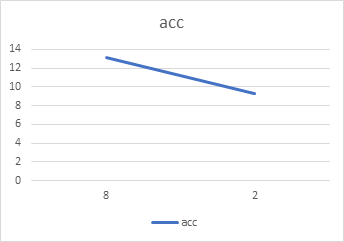

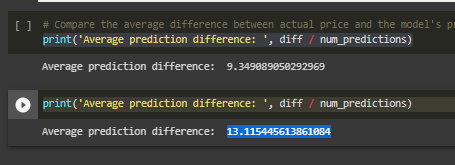